### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import string
import gc
import warnings
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

### Read data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df_train = pd.read_csv('/content/drive/My Drive/Datasets/train.csv')

In [0]:
df_test = pd.read_csv('/content/drive/My Drive/Datasets/test.csv')

### Initial Analysis

In [5]:
df_train['sentiment'].value_counts()

1    4311
2    2382
0     456
3     125
Name: sentiment, dtype: int64

Sentiment 3 doesnt give information about emotions of user. So dropping those sentiments

In [0]:
df_train = df_train.drop(df_train[df_train["sentiment"]==3].index)

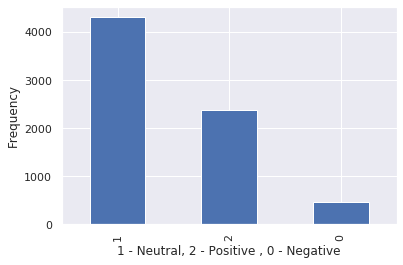

In [7]:
df_train['sentiment'].value_counts().plot(kind='bar')
plt.xlabel("1 - Neutral, 2 - Positive , 0 - Negative" )
plt.ylabel("Frequency");

In [8]:
df_train.isnull().sum()

tweet_id     0
tweet        1
sentiment    0
dtype: int64

In [9]:
df_test.isnull().sum()

tweet_id    0
tweet       0
dtype: int64

### Dropping blank tweet from train data.

In [0]:
df_train.dropna(axis=0,inplace=True)

In [0]:
""" function to clean the tweet """
def clean_tweet(text):
    text = str(text).lower()
    soup = BeautifulSoup(str(text), "lxml")
    soup_text = soup.get_text() 

    link_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', soup_text)
    link_text = re.sub(r'@[\w]*', '', soup_text)
    link_text = re.sub("{link}", " ", link_text)
    link_text = re.sub("rt", " ", link_text)
    
    try:
        clean = link_text.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = link_text
    letters_only = re.sub("[^#a-zA-Z]", " ", clean)
    return letters_only

### Combining train and test tweets for processing

In [0]:
total_df1 = pd.concat([ df_train["tweet"], df_test["tweet"]], 0)
total_df = pd.DataFrame(total_df1, columns=["tweet"])

### Replacing Sentiments with words

In [0]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# SadEmoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

def check_emoticon(txt):
  all_text=[]
  txt1 = str(txt).split()
  for t in txt1:
    for happy in emoticons_happy:
      if t == happy:
        all_text.append("happy")    
    for sad in emoticons_sad:
      if t == sad:
        all_text.append("sad")  
    else:
        all_text.append(txt1)

  result = ' '.join(all_text[0])

  return result

total_df.tweet = total_df.tweet.apply(lambda x: check_emoticon(x))


In [0]:
total_df.tweet = total_df.tweet.apply(clean_tweet)

In [15]:
total_df.head()

,tweet
0,#sxswnui #sxsw #apple defining language of tou...
1,learning ab google doodles all doodles should...
2,one of the most in your face ex of stealing t...
3,this iphone #sxsw app would b pretty awesome i...
4,line outside the apple store in austin waiting...


### Tokenize and only consider the words which are not sxsw

In [0]:
total_df.tweet = total_df.tweet.apply(lambda x: nltk.word_tokenize(x))

In [17]:
total_df.tweet

0       [#, sxswnui, #, sxsw, #, apple, defining, lang...
1       [learning, ab, google, doodles, all, doodles, ...
2       [one, of, the, most, in, your, face, ex, of, s...
3       [this, iphone, #, sxsw, app, would, b, pretty,...
4       [line, outside, the, apple, store, in, austin,...
                              ...                        
1814    [hmmm, how, fast, can, #, apple, build, a, new...
1815    [samsung, galaxy, s, ii, appears, at, fcc, and...
1816    [you, could, buy, a, new, ipad, tmrw, at, the,...
1817    [wow, very, long, queue, of, people, at, apple...
1818    [privacy, could, headline, google, circles, so...
Name: tweet, Length: 8967, dtype: object

In [0]:
def char_len(text):

  total_text=[]
  for w in text:
    if len(w.strip())>2:
      if "sxsw" not in w:
        total_text.append(w)
  return total_text
    
total_df.tweet = total_df.tweet.apply(lambda x: char_len(x))

In [19]:
total_df.head()

,tweet
0,"[apple, defining, language, touch, with, diffe..."
1,"[learning, google, doodles, all, doodles, shou..."
2,"[one, the, most, your, face, stealing, the, sh..."
3,"[this, iphone, app, would, pretty, awesome, di..."
4,"[line, outside, the, apple, store, austin, wai..."


### Stopwords Removal and Lemmatization

In [0]:
# stopwords removal
stop_words = list(set(stopwords.words('english')))+list(string.punctuation)+['``', "'s", "...", "n't"]
total_df.tweet = total_df.tweet.apply(lambda row: [word for word in row if word not in stop_words])
total_df.tweet = total_df.tweet.apply(lambda x: ' '.join(x))

In [0]:
# Performing lemmatization with appropraite pos tag
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer 

def lemmatize_all_with_pos(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        else:
            yield word

total_df.tweet = total_df.tweet.apply(lambda x: ' '.join(lemmatize_all_with_pos(x)))

In [22]:
total_df.head()

,tweet
0,apple define language touch different dialect ...
1,learn google doodle doodle light funny innovat...
2,one face steal show yrs apple school mkt expe
3,iphone app would pretty awesome crash every mi...
4,line outside apple store austin wait new ipad


### Chat words removal

In [0]:
chat_words_str = """AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The Ass
PRT=Party
PRW=Parents Are Watching
QPSA?=Que Pasa?
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My Ass Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TMRW=Tomorrow
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
YRS=Years
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The Fcuk
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick Laugher"""

# chat_words_str.split("\n")
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        cw_expanded = cw_expanded.lower()
        cw = cw.lower()
        chat_words_list.append(cw)
        
        chat_words_map_dict[cw] = cw_expanded

chat_words_list = set(chat_words_list)

# chat_words_map_dict
# chat_words_list

In [0]:
def chat_words_conversion(text):
  text = text.lower()
  new_text = []
  for w in text.split():

    if w.lower() in chat_words_list:
      new_text.append(chat_words_map_dict[w.lower()])
    else:
      new_text.append(w)
  return " ".join(new_text)

In [0]:
total_df.tweet = total_df.tweet.apply(chat_words_conversion)

### Removing frequent and rare words

In [0]:
#Common word removal
freq = pd.Series(' '.join(total_df.tweet).split()).value_counts()[:10]
freq1 = list(freq.index)
total_df.tweet = total_df.tweet.apply(lambda x: " ".join(x for x in x.split() if x not in freq1))

freq_rare = pd.Series(' '.join(total_df.tweet).split()).value_counts()[-10:]
freq_rare1 = list(freq_rare.index)
total_df.tweet = total_df.tweet.apply(lambda x: " ".join(x for x in str(x).split() if x not in freq_rare1))

In [27]:
print(df_train.shape)
print(df_test.shape)
print(total_df.shape)

(7148, 3)
(1819, 2)
(8967, 1)


In [39]:
total_df.head()

,tweet
0,define language touch different dialect become...
1,learn doodle doodle light funny innovative exc...
2,one face steal show years school mkt expe
3,would pretty awesome crash every min extend br...
4,line outside wait


In [0]:
total_df.to_csv("clean_data.csv")

### Creating Meta Features

In [0]:
STOPWORDS = list(set(stopwords.words('english')))

# word_count
total_df['word_count'] = total_df['tweet'].apply(lambda x: len(str(x).split()))
# df_test['word_count'] = df_test['tweet'].apply(lambda x: len(str(x).split()))

# unique_word_count
total_df['unique_word_count'] = total_df['tweet'].apply(lambda x: len(set(str(x).split())))
# df_test['unique_word_count'] = df_test['tweet'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
total_df['stop_word_count'] = total_df['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
# df_test['stop_word_count'] = df_test['tweet'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
total_df['mean_word_length'] = total_df['tweet'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
# df_test['mean_word_length'] = df_test['tweet'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
total_df['char_count'] = total_df['tweet'].apply(lambda x: len(str(x)))
# df_test['char_count'] = df_test['tweet'].apply(lambda x: len(str(x)))

# # punctuation_count
# df_train['punctuation_count'] = df_train['tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# df_test['punctuation_count'] = df_test['tweet'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# # hashtag_count
# df_train['hashtag_count'] = df_train['tweet'].apply(lambda x: len([c for c in str(x) if c == '#']))
# df_test['hashtag_count'] = df_test['tweet'].apply(lambda x: len([c for c in str(x) if c == '#']))

# # mention_count
# df_train['mention_count'] = df_train['tweet'].apply(lambda x: len([c for c in str(x) if c == '@']))
# df_test['mention_count'] = df_test['tweet'].apply(lambda x: len([c for c in str(x) if c == '@']))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [0]:
total_df.drop('stop_word_count',axis=1,inplace=True)

### Modelling

In [0]:
from pprint import pprint
from time import time
import logging

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint 

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, f1_score

In [0]:
vec = CountVectorizer(max_df=0.55,ngram_range= (1,2))

train_df_vec = vec.fit_transform(total_df.tweet.iloc[:7148])
test_df_vec = vec.transform(total_df.tweet.iloc[7148:])


tfidf_t = TfidfTransformer()
train_tfidf = tfidf_t.fit_transform(train_df_vec)
test_tfidf = tfidf_t.transform(test_df_vec)

# train_tfidf['word_count'] = total_df['word_count'].iloc[:7148]
# train_tfidf['unique_word_count'] = total_df['unique_word_count'].iloc[:7148]
# train_tfidf['mean_word_length'] = total_df['mean_word_length'].iloc[:7148]
# train_tfidf['char_count'] = total_df['char_count'].iloc[:7148]
# test_tfidf['word_count'] = total_df['word_count'].iloc[7148:]
# test_tfidf['unique_word_count'] = total_df['unique_word_count'].iloc[7148:]
# test_tfidf['mean_word_length'] = total_df['mean_word_length'].iloc[7148:]
# test_tfidf['char_count'] = total_df['char_count'].iloc[7148:]


#train test split
X_train,X_test,y_train,y_test = train_test_split(train_tfidf[:7148],df_train['sentiment'],test_size=0.3,random_state=1)


In [0]:
X_train.shape

(5003, 32957)

In [0]:
X_test.shape

(2145, 32957)

### Logistic Regression

In [0]:
# baseline logistic regression model - Test accuracy 0.67 
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred_train = logreg.predict(X_train)
y_pred = logreg.predict(X_test)

print("Train F1-score",f1_score(y_train,y_pred_train,average='weighted'))
print("Test F1-score",f1_score(y_test,y_pred,average='weighted'))
print("------------------------------")
print(classification_report(y_test,y_pred))

Train F1-score 0.8361042090182571
Test F1-score 0.6206539924403642
------------------------------
              precision    recall  f1-score   support

           0       0.83      0.03      0.07       143
           1       0.67      0.93      0.78      1283
           2       0.69      0.34      0.45       719

    accuracy                           0.67      2145
   macro avg       0.73      0.43      0.43      2145
weighted avg       0.69      0.67      0.62      2145



In [0]:
# On actual test data - submission score 0.65
logreg.fit(train_tfidf,df_train['sentiment'])
y_pred_test = logreg.predict(test_tfidf)
submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_basic_logreg.csv",index=False)

### Naive Bayes

In [0]:
# train - test split ( test accuracy - 0.61)
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=1e-05)
nb.fit(X_train,y_train)

y_pred_train = nb.predict(X_train)
y_pred = nb.predict(X_test)

print("Train F1-score",f1_score(y_train,y_pred_train,average='weighted'))
print("Test F1-score",f1_score(y_test,y_pred,average='weighted'))
print("------------------------------")
print(classification_report(y_test,y_pred))

Train F1-score 0.9518987956371422
Test F1-score 0.6203957321258878
------------------------------
              precision    recall  f1-score   support

           0       0.26      0.38      0.31       143
           1       0.74      0.65      0.69      1283
           2       0.52      0.59      0.55       719

    accuracy                           0.61      2145
   macro avg       0.51      0.54      0.52      2145
weighted avg       0.64      0.61      0.62      2145



In [0]:
# on actual test data - submission score 0.63
nb.fit(train_tfidf, df_train["sentiment"])
y_pred_test = nb.predict(test_tfidf)
submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_nb_tts.csv",index=False)

### SGD - SVM

In [0]:
# train - test split (test accuracy - 0.68)
sgd = SGDClassifier(alpha=1e-05,max_iter=50,penalty='elasticnet', random_state=19097)
sgd.fit(X_train,y_train)

y_pred_train = sgd.predict(X_train)
y_pred = sgd.predict(X_test)

print("Train F1-score",f1_score(y_train,y_pred_train,average='weighted'))
print("Test F1-score",f1_score(y_test,y_pred,average='weighted'))
print("------------------------------")
print(classification_report(y_test,y_pred))

Train F1-score 0.9618078975097558
Test F1-score 0.6615014073909833
------------------------------
              precision    recall  f1-score   support

           0       0.60      0.20      0.30       143
           1       0.71      0.84      0.77      1283
           2       0.61      0.49      0.55       719

    accuracy                           0.68      2145
   macro avg       0.64      0.51      0.54      2145
weighted avg       0.67      0.68      0.66      2145



In [0]:
# In case of sgd classifier if loss is 'hinge' it performs as svm and if loss is 'log' it performs as logistic regression
# sgd as svm
# actual test data (submission score - 0.66)
sgd = SGDClassifier(alpha=1e-05,max_iter=50,penalty='elasticnet', random_state=1)
sgd.fit(train_tfidf, df_train["sentiment"])

y_pred_test = sgd.predict(test_tfidf)

submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_sgd_svm_tts.csv",index=False)

### SGD - Logistic Regression

In [0]:
# train - test split (test accuracy - 0.68)
sgd = SGDClassifier(alpha=1e-05,max_iter=50,penalty='elasticnet',loss="log", random_state=900)
sgd.fit(X_train,y_train)

y_pred_train = sgd.predict(X_train)
y_pred = sgd.predict(X_test)

print("Train F1-score",f1_score(y_train,y_pred_train,average='weighted'))
print("Test F1-score",f1_score(y_test,y_pred,average='weighted'))
print("------------------------------")
print(classification_report(y_test,y_pred))

Train F1-score 0.9603812368720243
Test F1-score 0.6554503550678125
------------------------------
              precision    recall  f1-score   support

           0       0.61      0.15      0.25       143
           1       0.70      0.86      0.77      1283
           2       0.64      0.46      0.53       719

    accuracy                           0.68      2145
   macro avg       0.65      0.49      0.52      2145
weighted avg       0.67      0.68      0.66      2145



In [0]:
# sgd as logistic regression (submission score - 0.67)
sgd = SGDClassifier(alpha=1e-05,max_iter=50,penalty='elasticnet',loss="log", random_state=96)
sgd.fit(train_tfidf,df_train["sentiment"])

y_pred_test = sgd.predict(test_tfidf)

submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_sgd_logreg_tts.csv",index=False)

### Random Forest

In [0]:
# train test split (test accuracy - 0.68)
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print("Train F1-score",f1_score(y_train,y_pred_train,average='weighted'))
print("Test F1-score",f1_score(y_test,y_pred,average='weighted'))
print("------------------------------")
print(classification_report(y_test, y_pred))

Train F1-score 0.9601848049390492
Test F1-score 0.650064693927844
------------------------------
              precision    recall  f1-score   support

           0       0.61      0.15      0.25       143
           1       0.68      0.88      0.77      1283
           2       0.66      0.42      0.52       719

    accuracy                           0.68      2145
   macro avg       0.65      0.49      0.51      2145
weighted avg       0.67      0.68      0.65      2145



In [0]:
# actual test data (submission score - 0.65)
rf.fit(train_tfidf,df_train["sentiment"])

y_pred_test = rf.predict(test_tfidf)
submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_rf_tts.csv",index=False)

### SVC grid search pipeline

In [0]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC()),
    # ('xg', XGBClassifier(random_state=42))
])

parameters = {
    'vect__max_df': (0.55,0.67),
    # 'vect__max_features': (None, 5000),
    'vect__ngram_range': ((1,2),(1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__random_state':(1,42),
    # 'clf__max_iter': (20,10,80),
    'clf__C': (0.01,1),
    'clf__kernel' : ('linear','rbf'),
    'clf__degree' : (2,3),
    'clf__gamma' : ('scale','auto')
    # 'clf__penalty': ('l2','l1', 'elasticnet'),
    # 'clf__max_iter': (50, 55),
}

# C=1.0, cache_size=200, class_weight=None,
# coef0=0.0, decision_function_shape='ovr',
# degree=3, gamma='auto_deprecated',
# kernel='linear'

grid_search = GridSearchCV(pipeline, parameters, cv=5,
                               n_jobs=-1, verbose=1)


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
# grid_search.fit(total_df.tweet.iloc[:7274], df["sentiment"])
grid_search.fit(total_df.tweet.iloc[:7148], df_train["sentiment"])
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):

  print("\t%s: %r" % (param_name, best_parameters[param_name]))





Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__C': (0.01, 1),
 'clf__degree': (2, 3),
 'clf__gamma': ('scale', 'auto'),
 'clf__kernel': ('linear', 'rbf'),
 'clf__random_state': (1, 42),
 'vect__max_df': (0.55, 0.67),
 'vect__ngram_range': ((1, 2), (1, 2))}
Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 44.0min finished


done in 2645.857s

Best score: 0.694
Best parameters set:
	clf__C: 1
	clf__degree: 2
	clf__gamma: 'scale'
	clf__kernel: 'linear'
	clf__random_state: 1
	vect__max_df: 0.55
	vect__ngram_range: (1, 2)


In [0]:
# Best score: 0.694
# Best parameters set:
# 	clf__C: 1
# 	clf__degree: 2
# 	clf__gamma: 'scale'
# 	clf__kernel: 'linear'
# 	clf__random_state: 1
# 	vect__max_df: 0.55
# 	vect__ngram_range: (1, 2)

from sklearn.decomposition import TruncatedSVD
vec = CountVectorizer(max_df=0.50,ngram_range= (1,2))
train_df_vec = vec.fit_transform(total_df.tweet.iloc[:7148])
test_df_vec = vec.transform(total_df.tweet.iloc[7148:])

tfidf_t = TfidfTransformer()
train_tfidf = tfidf_t.fit_transform(train_df_vec)
test_tfidf = tfidf_t.transform(test_df_vec)

train_tfidf = train_tfidf
test_tfidf = test_tfidf

from sklearn.svm import SVC
svm = SVC(kernel='linear',gamma='scale',degree=2,C=1,random_state=42,verbose=1)
svm.fit(train_tfidf, df_train["sentiment"])
y_pred_test = svm.predict(test_tfidf)

# print(pd.Series(y_pred_test).value_counts())

submit_id=list(df_test["tweet_id"])
submit_pred=list(y_pred_test)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_svcgrid__pipeline.csv",index=False)

[LibSVM]

### Light GBM

In [0]:
import lightgbm as lgbm
from lightgbm import LGBMClassifier

In [0]:
clf_LGBM = lgbm.LGBMClassifier(objective='multiclass', verbose=-1, learning_rate=0.5, max_depth=20, num_leaves=50, n_estimators=120, max_bin=2000,)
clf_LGBM.fit(train_tfidf, df_train["sentiment"])
predicted_LGBM = clf_LGBM.predict(test_tfidf)

In [0]:
submit_id=list(df_test["tweet_id"])
submit_pred=list(predicted_LGBM)
final_submission =pd.DataFrame(list(zip(submit_id, submit_pred)), columns =['tweet_id', 'sentiment'])
final_submission.to_csv("submission_lgbm_tts.csv",index=False)

### Topic Modelling

In [0]:
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [0]:
train_df = total_df.iloc[:7148]

In [0]:
data = train_df.tweet.copy()
data = data.apply(lambda x: x.split()) # cleaned doc
id2word = corpora.Dictionary(data) # dictonary

In [0]:
corpus = [id2word.doc2bow(text) for text in data] # doctermmatrix

In [32]:
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [33]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('become', 1),
  ('define', 1),
  ('dialect', 1),
  ('different', 1),
  ('language', 1),
  ('small', 1),
  ('touch', 1)]]

In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [35]:
pprint(lda_model.print_topics())

[(0,
  '0.038*"pop" + 0.030*"open" + 0.027*"android" + 0.026*"line" + 0.022*"via" + '
  '0.022*"mobile" + 0.021*"win" + 0.018*"come" + 0.014*"temporary" + '
  '0.014*"apps"'),
 (1,
  '0.052*"circle" + 0.049*"social" + 0.038*"network" + 0.036*"today" + '
  '0.025*"call" + 0.023*"major" + 0.018*"possibly" + 0.017*"good" + '
  '0.016*"set" + 0.016*"need"'),
 (2,
  '0.017*"free" + 0.016*"go" + 0.015*"tech" + 0.014*"people" + 0.014*"day" + '
  '0.012*"last" + 0.012*"year" + 0.012*"map" + 0.011*"use" + 0.011*"week"'),
 (3,
  '0.019*"see" + 0.015*"show" + 0.015*"great" + 0.014*"one" + 0.014*"make" + '
  '0.012*"like" + 0.012*"time" + 0.011*"popup" + 0.010*"know" + 0.010*"work"')]


### Coherence score to find optimal no of topics

In [37]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

  """
  Compute c_v coherence for various number of topics

  Parameters:
  ----------
  dictionary : Gensim dictionary
  corpus : Gensim corpus
  texts : List of input texts
  limit : Max num of topics

  Returns:
  -------
  model_list : List of LDA topic models
  coherence_values : Coherence values corresponding to the LDA model with respective number of topics
  """
  coherence_values = []
  model_list = []
  for num_topics in range(start, limit, step):
    print("num_topics",str(num_topics))
    Lda = gensim.models.ldamodel.LdaModel
    model = Lda(corpus, num_topics, id2word = dictionary, passes=50)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

  return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data, start=2, limit=40, step=2)

num_topics 2
num_topics 4
num_topics 6
num_topics 8
num_topics 10
num_topics 12
num_topics 14
num_topics 16
num_topics 18
num_topics 20
num_topics 22
num_topics 24
num_topics 26
num_topics 28
num_topics 30
num_topics 32
num_topics 34
num_topics 36
num_topics 38


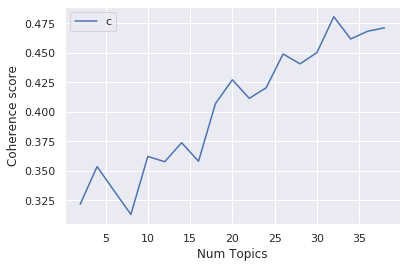

In [39]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3217
Num Topics = 4  has Coherence Value of 0.3536
Num Topics = 6  has Coherence Value of 0.3333
Num Topics = 8  has Coherence Value of 0.3131
Num Topics = 10  has Coherence Value of 0.3623
Num Topics = 12  has Coherence Value of 0.3578
Num Topics = 14  has Coherence Value of 0.3739
Num Topics = 16  has Coherence Value of 0.3581
Num Topics = 18  has Coherence Value of 0.407
Num Topics = 20  has Coherence Value of 0.4272
Num Topics = 22  has Coherence Value of 0.4115
Num Topics = 24  has Coherence Value of 0.4204
Num Topics = 26  has Coherence Value of 0.449
Num Topics = 28  has Coherence Value of 0.4407
Num Topics = 30  has Coherence Value of 0.4502
Num Topics = 32  has Coherence Value of 0.4806
Num Topics = 34  has Coherence Value of 0.4618
Num Topics = 36  has Coherence Value of 0.4683
Num Topics = 38  has Coherence Value of 0.4712


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 18 topics itself.

### Dominant Topic Analysis

In [0]:
# lda model selecting 4 topics for efficency

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [0]:
def format_topics_sentences(lda_model = None, corpus = corpus, texts = data):
  sent_topics_df = pd.DataFrame()

  for i, row_list in enumerate(lda_model[corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list

    # print(row)
    # break

    row = sorted(row, key=lambda x: (x[1]),reverse=True)
    # print(row)
    for j, (topic_num, prop_topic) in enumerate(row):

      if j == 0: # a dominant topic
        wp = lda_model.show_topic(topic_num)
        topic_keywords = ", ".join([word for word,prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
      else:
        break

  sent_topics_df.columns = ["Dominant_Topic", "%Contribution", "Topic_Keywords"]
  contents = pd.Series(texts)
  sent_topics_df=pd.concat([sent_topics_df,contents],1)
  return (sent_topics_df)

In [0]:
df_topic_sents_keywords = format_topics_sentences(lda_model=lda_model, corpus=corpus, texts=data)

In [0]:
df_dominant_topic = df_topic_sents_keywords.reset_index()

In [45]:
df_dominant_topic.tail()

,index,Dominant_Topic,%Contribution,Topic_Keywords,tweet
7266,7269,NaN,NaN,NaN,"[plze, tammi, middle, craziness, everything, s..."
7267,7270,NaN,NaN,NaN,"[set, edchat, musedchat, newtwitter]"
7268,7271,NaN,NaN,NaN,"[aha, find, proof, lactation, room, excuse, mo..."
7269,7272,NaN,NaN,NaN,"[detail, first, edition, free]"
7270,7273,NaN,NaN,NaN,"[next, fin, serv, battle, goog, mobile, operat..."


In [0]:
df_dominant = df_dominant_topic[~df_dominant_topic.Topic_Keywords.isnull()]

In [61]:
df_dominant.head(10)

,index,Dominant_Topic,%Contribution,Topic_Keywords,tweet
0,0,3.0,0.4556,"see, show, great, one, make, like, time, popup...","[define, language, touch, different, dialect, ..."
1,1,3.0,0.3980,"see, show, great, one, make, like, time, popup...","[learn, doodle, doodle, light, funny, innovati..."
2,2,3.0,0.4200,"see, show, great, one, make, like, time, popup...","[one, face, steal, show, years, school, mkt, e..."
3,3,1.0,0.5466,"circle, social, network, today, call, major, p...","[would, pretty, awesome, crash, every, min, ex..."
4,4,0.0,0.8125,"pop, open, android, line, via, mobile, win, co...","[line, outside, wait]"
5,5,2.0,0.6763,"free, go, tech, people, day, last, year, map, ...","[technews, one, lone, dude, await, tech, news,..."
6,6,2.0,0.9014,"free, go, tech, people, day, last, year, map, ...","[tip, prince, npr, videos, toy, shopping, zuck..."
7,7,2.0,0.8929,"free, go, tech, people, day, last, year, map, ...","[user, ubersocial, include, uberguide, sponsor..."
8,8,2.0,0.8476,"free, go, tech, people, day, last, year, map, ...","[free, sampler, itunes, freemusic]"
9,9,3.0,0.4698,"see, show, great, one, make, like, time, popup...","[think, might, weekend, without, see, case, tw..."


### WordCloud

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [0]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()]

In [0]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=12,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0
                  )

In [0]:
topics = lda_model.show_topics(formatted=False)

In [59]:
topics

[(0,
  [('pop', 0.038278155),
   ('open', 0.02995769),
   ('android', 0.02720077),
   ('line', 0.026412966),
   ('via', 0.022136528),
   ('mobile', 0.021908784),
   ('win', 0.020575993),
   ('come', 0.01839134),
   ('temporary', 0.014398936),
   ('apps', 0.013534075)]),
 (1,
  [('circle', 0.051601406),
   ('social', 0.048923038),
   ('network', 0.03761924),
   ('today', 0.03581819),
   ('call', 0.025436506),
   ('major', 0.023021339),
   ('possibly', 0.017842209),
   ('good', 0.017111512),
   ('set', 0.016378792),
   ('need', 0.015644867)]),
 (2,
  [('free', 0.017481793),
   ('go', 0.016265819),
   ('tech', 0.014774867),
   ('people', 0.013641112),
   ('day', 0.013561899),
   ('last', 0.012472648),
   ('year', 0.012424415),
   ('map', 0.011693267),
   ('use', 0.011346916),
   ('week', 0.011206416)]),
 (3,
  [('see', 0.018930346),
   ('show', 0.01512062),
   ('great', 0.014519017),
   ('one', 0.014011704),
   ('make', 0.013946859),
   ('like', 0.011948459),
   ('time', 0.011720482),
   

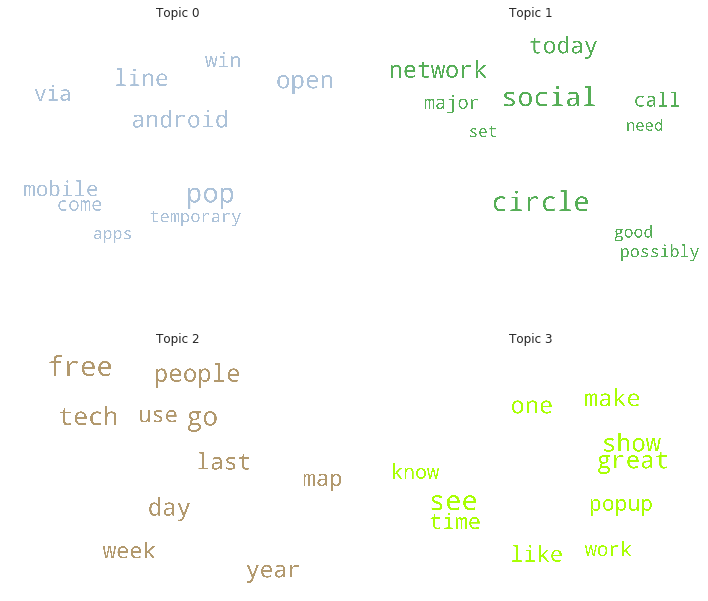

In [60]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  topic_words = dict(topics[i][1])
  cloud.generate_from_frequencies(topic_words, max_font_size=200)
  plt.gca().imshow(cloud)
  plt.gca().set_title("Topic "+str(i))
  plt.gca().axis("off")

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0,y=0)
plt.tight_layout()
# plt.show()

Topic 0 - android mobile
Topic 1 - Facebook live video 
Topic 2 - 
Topic 3 - Network issues

In [0]:
import 